# Cavities reference phase

## Definitions

There are three ways to define the reference phase of a cavity:
- by its relative entry phase $\phi_{0,\,\mathrm{rel}}$,
- its absolute entry phase $\phi_{0,\,\mathrm{abs}}$,
- its synchronous phase $\phi_s$.

A cavity reference phase controls its behavior when the beam phase differs from the baseline, which happens downstream of a failure if the beam absolute phase was not recovered.
- `"phi_0_abs"`: the cavity is not rephased.
- `"phi_0_rel"`: $\phi_{0,\,\mathrm{rel}}$ is preserved, so that the beam always "sees" the same RF phase.
- `"phi_s"`: $\phi_s$ is preserved, so that the cavity acceptance stays the same.

The relation between relative and entry phases is:
\begin{equation}
E_0\cos{\phi_{0,\,\mathrm{abs}}} = E_0\cos{(\phi_{0,\,\mathrm{rel}} + \phi_\mathrm{in})}
\end{equation}
where $\phi_\mathrm{in}$ is the phase at which the synchronous particle enters the cavity, $E_0$ is the amplitude of the electric field.

There is no analytic relation between $phi_s$ and the RF phases $\phi_{0,\,\mathrm{rel}}$, $\phi_{0,\,\mathrm{abs}}$. Hereby, when the reference phase of a cavity is $phi_s$, calculations are performed to find the actual RF phase allowing to retrieve $phi_s$. Those calculations can take some time.

The cavities reference phases are set by the `reference_phase_policy` entry in the `beam_calculator` section of the `TOML` file:
- `"phi_0_rel"`, `"phi_0_abs"` or `"phi_s"`: use this phase as reference
- `"as_in_original_dat"`: keep the reference stated in the `DAT` file, following the `SET_SYNC_PHASE` and the `FLAG_PHI_ABS` value of the `FIELD_MAP` commands.
  - Different cavities can have different reference phase!

In the rest of this notebook, we illustrate these differences and their impact on the beam dynamics.

## Preparation

### Load libraries

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt

from lightwin.config.config_manager import process_config
from lightwin.beam_calculation.beam_calculator import BeamCalculator
from lightwin.beam_calculation.factory import BeamCalculatorsFactory
from lightwin.beam_calculation.simulation_output.simulation_output import SimulationOutput
from lightwin.core.accelerator.accelerator import Accelerator
from lightwin.core.accelerator.factory import NoFault, WithFaults
from lightwin.failures.fault_scenario import FaultScenario, fault_scenario_factory
from lightwin.visualization import plot
from lightwin.constants import example_config, example_results
from lightwin.util.log_manager import set_up_logging

plt.rcParams["figure.figsize"] = (15, 5)

### Set the different solvers

In [2]:
CONFIG_KEYS = {
    'files': 'files',
    'beam_calculator': 'generic_envelope1d',
    'beam': 'beam',
    'plots': 'plots_minimal',
    'wtf': 'generic_wtf',
    'design_space': 'generic_design_space',
}

#### Linac with absolute reference phase

In [3]:
override = {
    'beam_calculator': {'reference_phase_policy': "phi_0_abs"},
    'plots': {'energy': False, "add_objectives": False, "twiss": False},
    'wtf': {'objective_preset': 'EnergyPhaseMismatch'},
}
config_abs = process_config(example_config, CONFIG_KEYS, warn_mismatch=True, override=override)

# We will use this for plots representing cavity settings, phase
plots_phase = config_abs['plots']

factory = BeamCalculatorsFactory(**config_abs)
solver_abs = factory.run_all()[0]

[INFO    ] [log_manager.py      ] Starting log for LightWin - Version: 0.11.3.dev1+gf954f555, Commit: a38643c05793ddfa0eab6ad5b2bacab9802e2541
[INFO    ] [files_specs.py      ] Setting project_path = PosixPath('/home/placais/LightWin/src/lightwin/data/ads/lw_results')
Setting log_file = 'lightwin.log'


#### Linac with relative reference phase

In [4]:
override = {
    'beam_calculator': {'reference_phase_policy': "phi_0_rel"},
    'plots': {'cav': True, "add_objectives": False, "twiss": False},
    'wtf': {'objective_preset': 'EnergyMismatch'},
}
config_rel = process_config(example_config, CONFIG_KEYS, warn_mismatch=True, override=override)

# We will use this for plots representing cavity settings, phase, energy
plots_complete = config_rel['plots']

factory = BeamCalculatorsFactory(**config_rel)
solver_rel = factory.run_all()[0]

[INFO    ] [table_spec.py       ] .toml table [files] loaded!
[INFO    ] [table_spec.py       ] .toml table [beam] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_envelope1d] loaded!
[INFO    ] [table_spec.py       ] .toml table [plots_minimal] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_design_space] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_wtf] loaded!
[INFO    ] [log_manager.py      ] Starting log for LightWin - Version: 0.11.3.dev1+gf954f555, Commit: a38643c05793ddfa0eab6ad5b2bacab9802e2541
[INFO    ] [files_specs.py      ] Setting project_path = PosixPath('/home/placais/LightWin/src/lightwin/data/ads/lw_results')
Setting log_file = 'lightwin.log'


### Linac with synchronous reference phase

In [5]:
override = {
    'beam_calculator': {'reference_phase_policy': "phi_s"},
    'wtf': {'objective_preset': 'EnergyMismatch'},
}
config_sync = process_config(example_config, CONFIG_KEYS, warn_mismatch=True, override=override)

factory = BeamCalculatorsFactory(**config_sync)
solver_sync = factory.run_all()[0]

[INFO    ] [table_spec.py       ] .toml table [files] loaded!
[INFO    ] [table_spec.py       ] .toml table [beam] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_envelope1d] loaded!
[INFO    ] [table_spec.py       ] .toml table [plots_minimal] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_design_space] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_wtf] loaded!
[INFO    ] [log_manager.py      ] Starting log for LightWin - Version: 0.11.3.dev1+gf954f555, Commit: a38643c05793ddfa0eab6ad5b2bacab9802e2541
[INFO    ] [files_specs.py      ] Setting project_path = PosixPath('/home/placais/LightWin/src/lightwin/data/ads/lw_results')
Setting log_file = 'lightwin.log'


### Set Accelerator objects

In [6]:
logging.getLogger().setLevel(logging.WARNING)

factory = WithFaults(beam_calculators=solver_abs, **config_abs)
accelerators_abs = factory.run_all()
for acc in accelerators_abs:
    acc.name += r' (absolute $\phi_0$)'
working_abs = accelerators_abs[0]
broken_abs = accelerators_abs[1]

factory = WithFaults(beam_calculators=solver_rel, **config_rel)
accelerators_rel = factory.run_all()
for acc in accelerators_rel:
    acc.name += r' (relative $\phi_0$)'
working_rel = accelerators_rel[0]
broken_rel = accelerators_rel[1]

factory = WithFaults(beam_calculators=solver_sync, **config_sync)
accelerators_sync = factory.run_all()
for acc in accelerators_sync:
    acc.name += r' ($\phi_s$)'
working_sync = accelerators_sync[0]
broken_sync = accelerators_sync[1]

working_linacs = (working_abs, working_rel, working_sync)
broken_linacs = (broken_abs, broken_rel, broken_sync)
solvers = (solver_abs, solver_rel, solver_sync)

## Propagate the beam

### Nominal linac

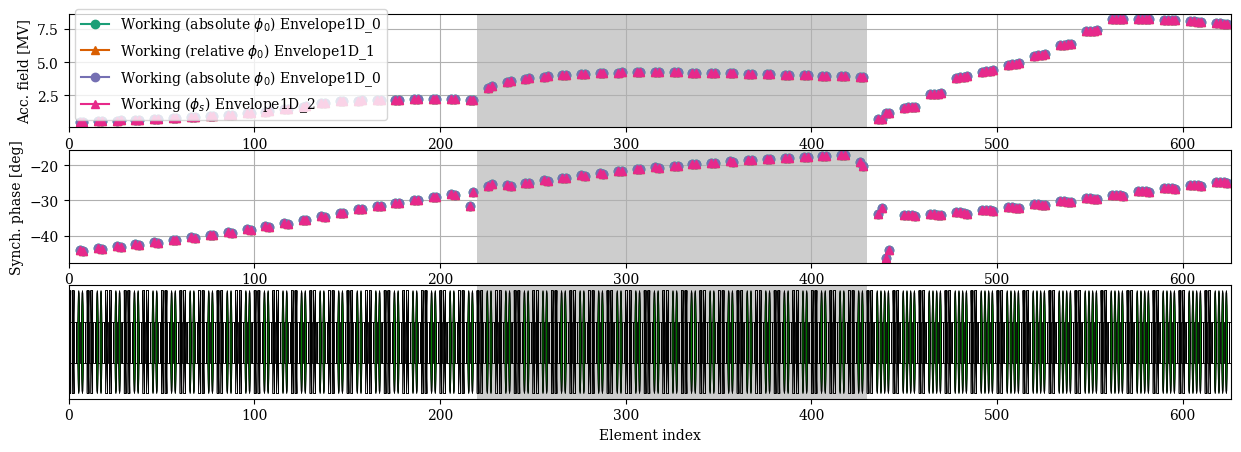

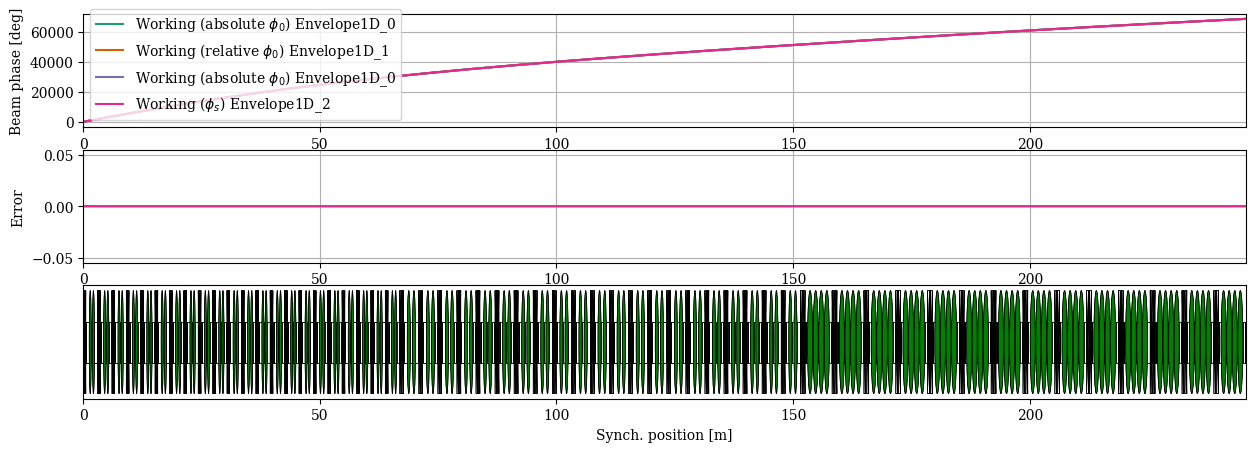

In [7]:
for solver, linac in zip(solvers, working_linacs):
    _ = solver.compute(linac)
figs = plot.factory(working_linacs, plots_phase, save_fig=False, clean_fig=False)

In the nominal linac, there is no difference between the different reference phases.

<div class="alert alert-info">
The reference $\phi_0$ that is used is the one defined in the `DAT`.
As a matter of a fact, we need to propagate the beam a first time to know the entry phase of the synchronous particle in every cavity.
This quantity is necessary to link $\phi_{0,\,\mathrm{abs}}$ with $\phi_{0,\,\mathrm{rel}}$.
</div>

## Linac with one broken cavity

### Absolute reference phase

In [8]:
fault_scenarios_abs = fault_scenario_factory(accelerators_abs, solver_abs, config_abs['wtf'], config_abs['design_space'])

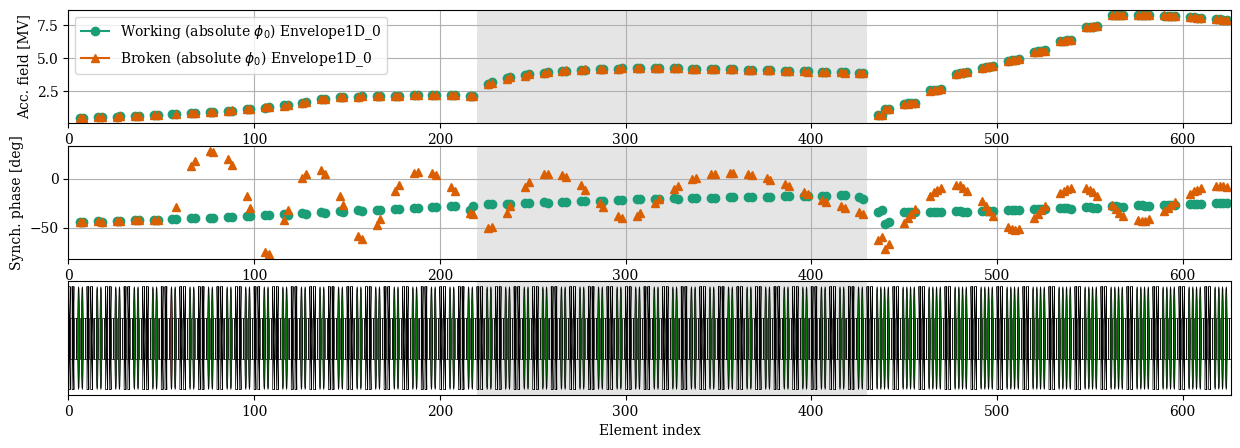

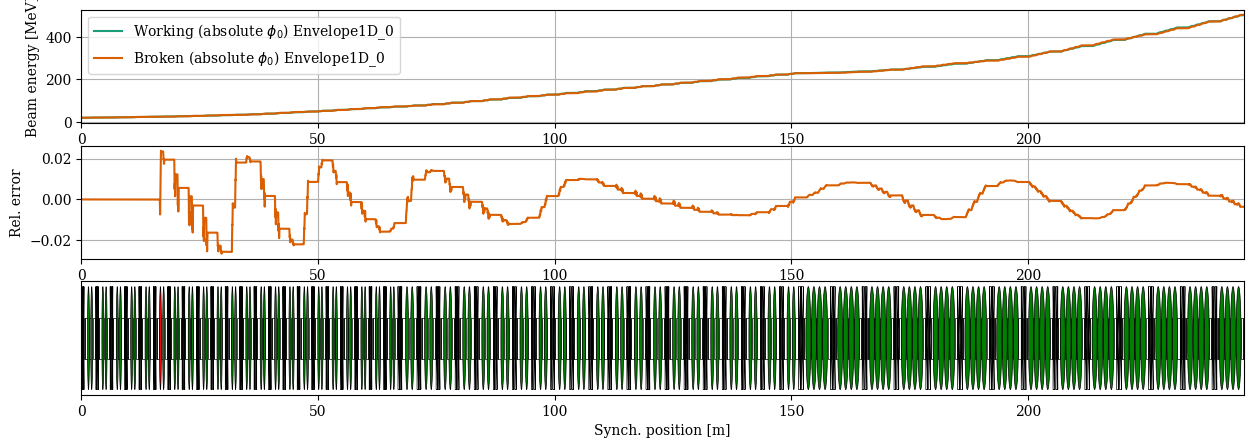

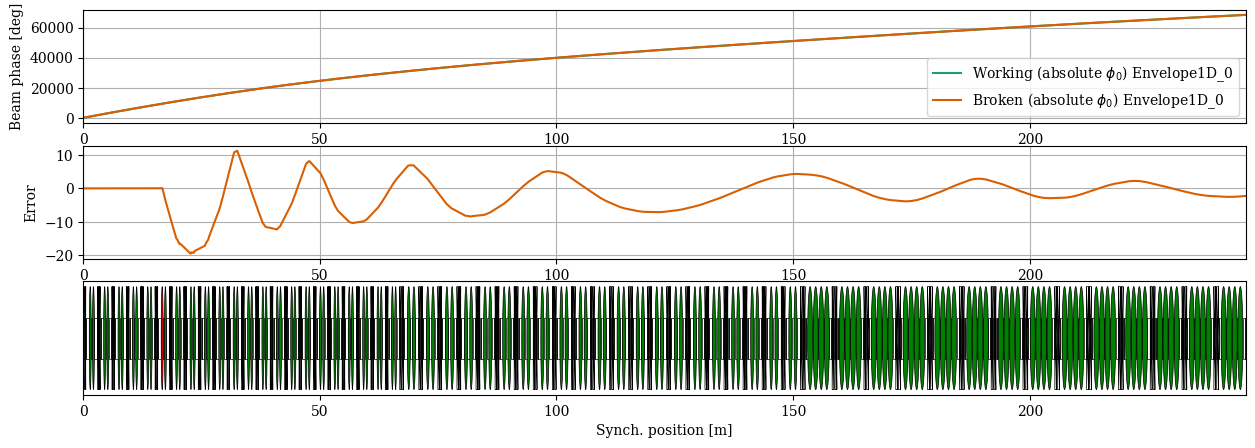

In [9]:
_ = solver_abs.compute(broken_abs)
figs = plot.factory(accelerators_abs, plots_complete, save_fig=False, clean_fig=False)

Cavities in their nominal tuning are green, and the failed cavity is represented in red.
Here the beam energy and phase remain very close to the baseline. However, the positive synchronous phases show that high losses would be to expect.

### Relative reference phase

In [10]:
fault_scenarios_rel = fault_scenario_factory(accelerators_rel, solver_rel, config_rel['wtf'], config_rel['design_space'])

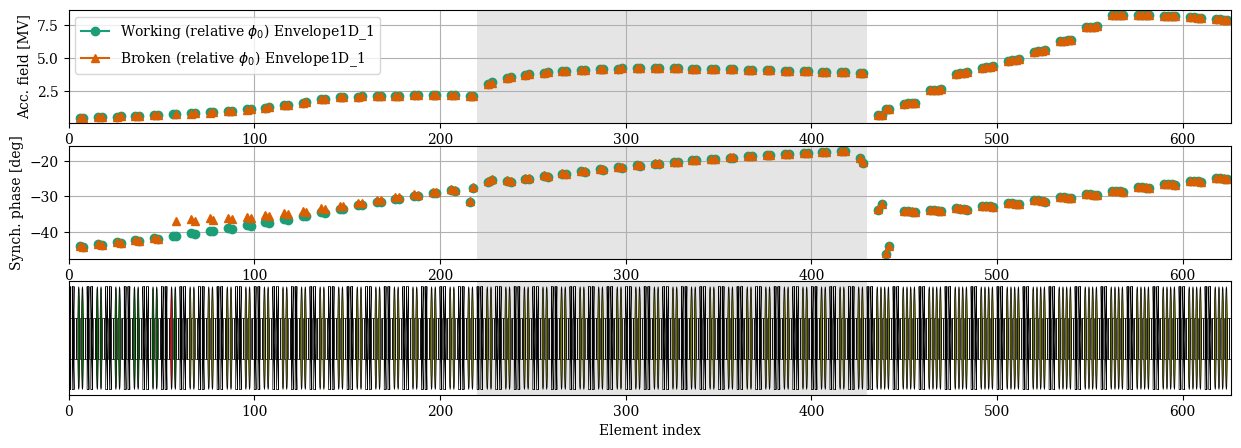

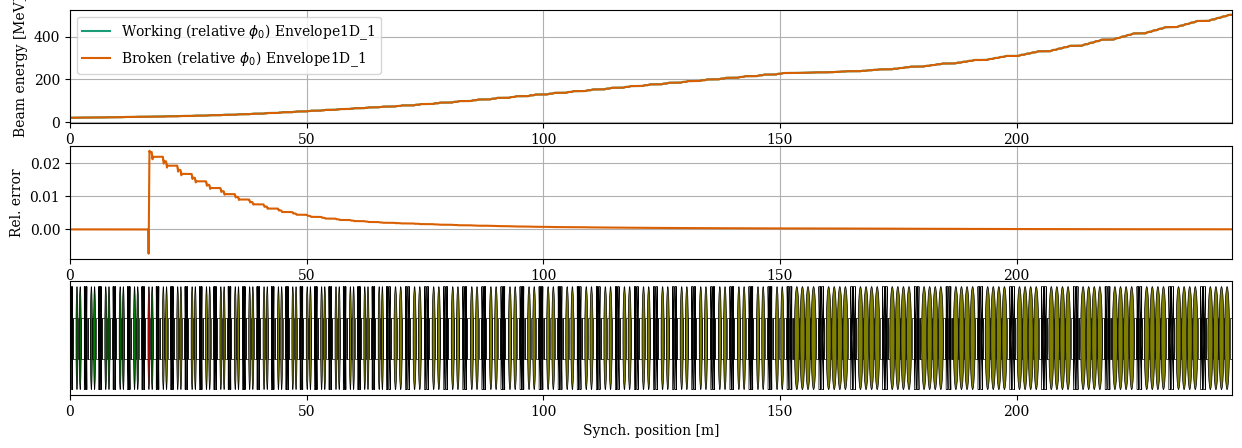

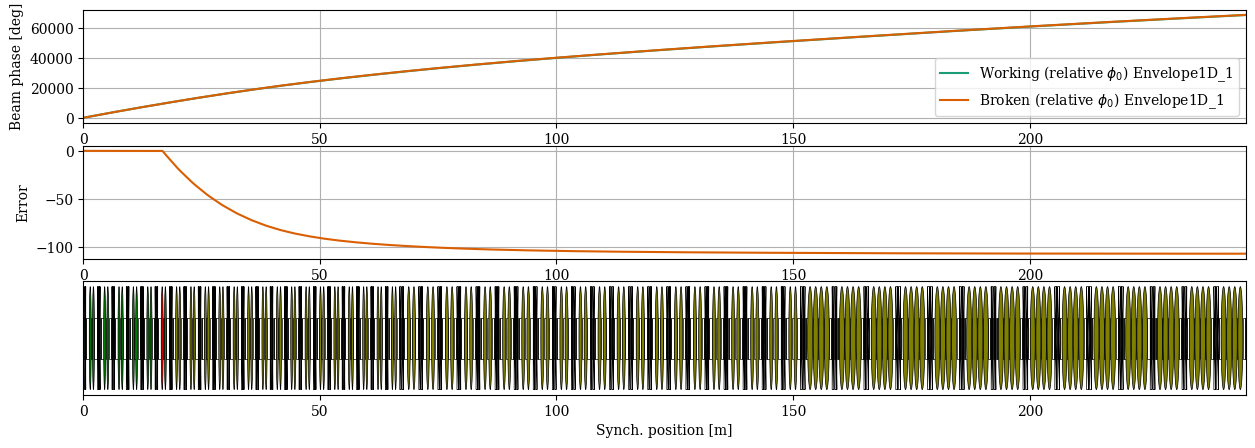

In [11]:
_ = solver_rel.compute(broken_rel)
figs = plot.factory(accelerators_rel, plots_complete, save_fig=False, clean_fig=False)

In this example, the error on the beam energy is progressively damped. In LightWin, rephased cavities are represented with olive color.

### Synchronous reference phase

In [12]:
fault_scenarios_sync = fault_scenario_factory(accelerators_sync, solver_sync, config_sync['wtf'], config_sync['design_space'])

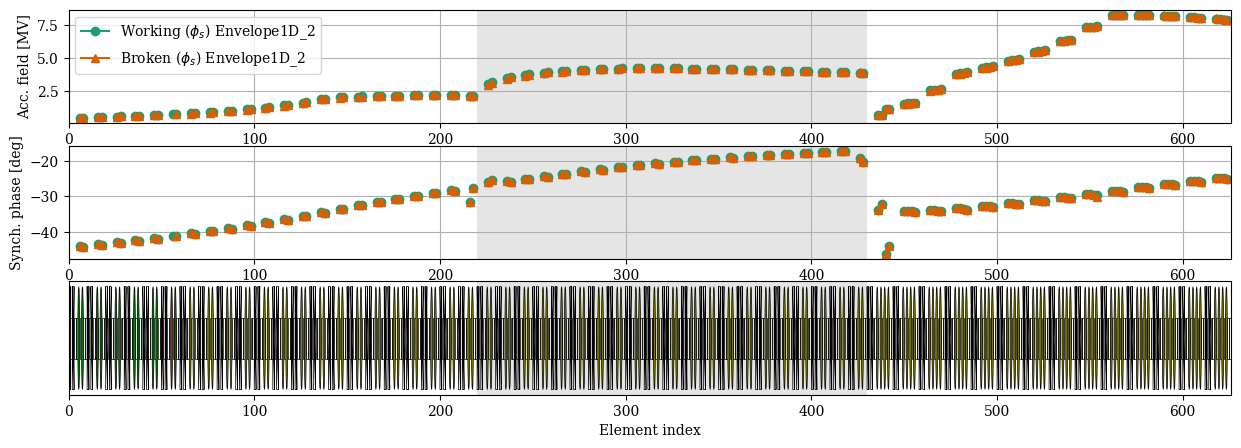

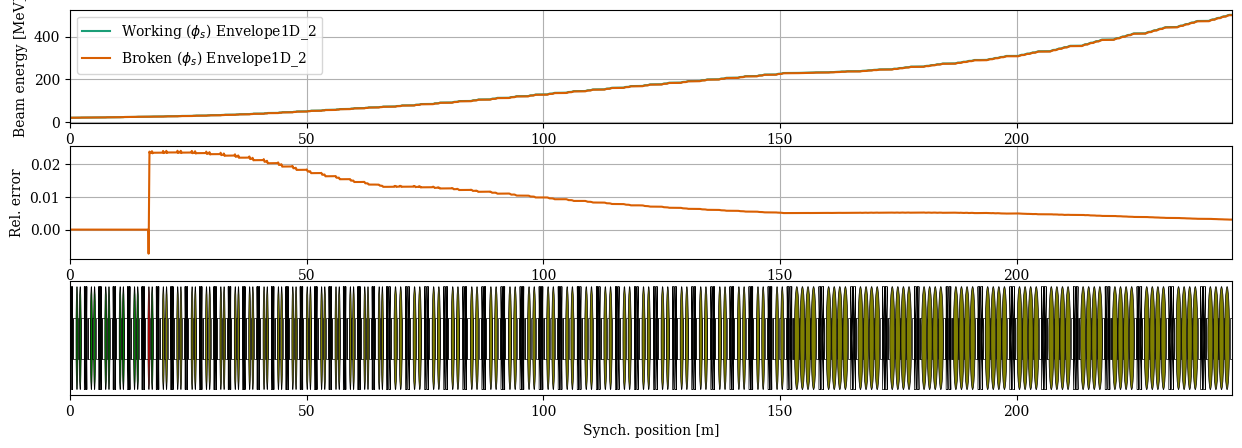

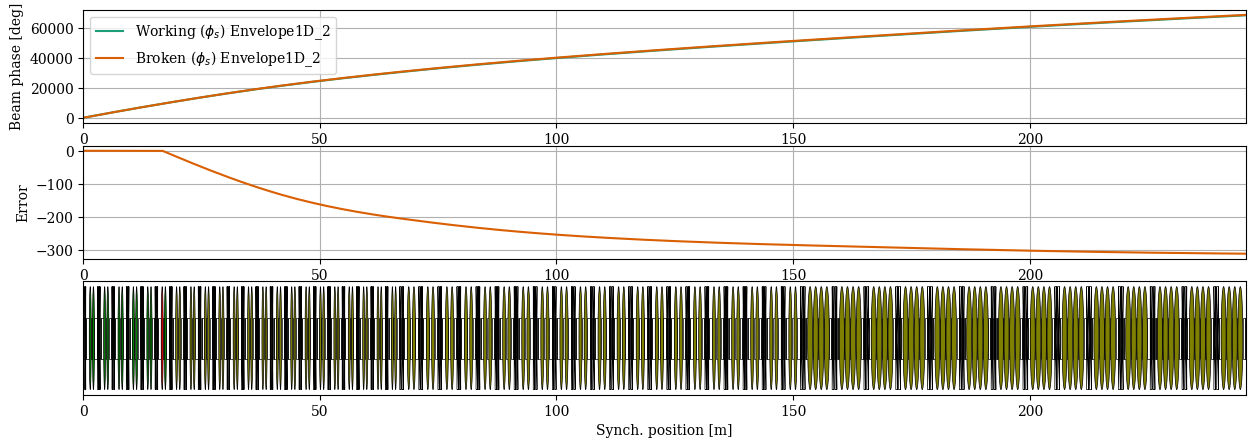

In [13]:
_ = solver_sync.compute(broken_sync)
figs = plot.factory(accelerators_sync, plots_complete, save_fig=False, clean_fig=False)

Notice that the synchronous phases are unaffected by failed cavity.

## Fixing the fault

### Absolute phase linac

For the absolute phase linac, we try to retrieve the energy and the phase at the end of the compensation zone, as well as to minimize the mismatch factor.

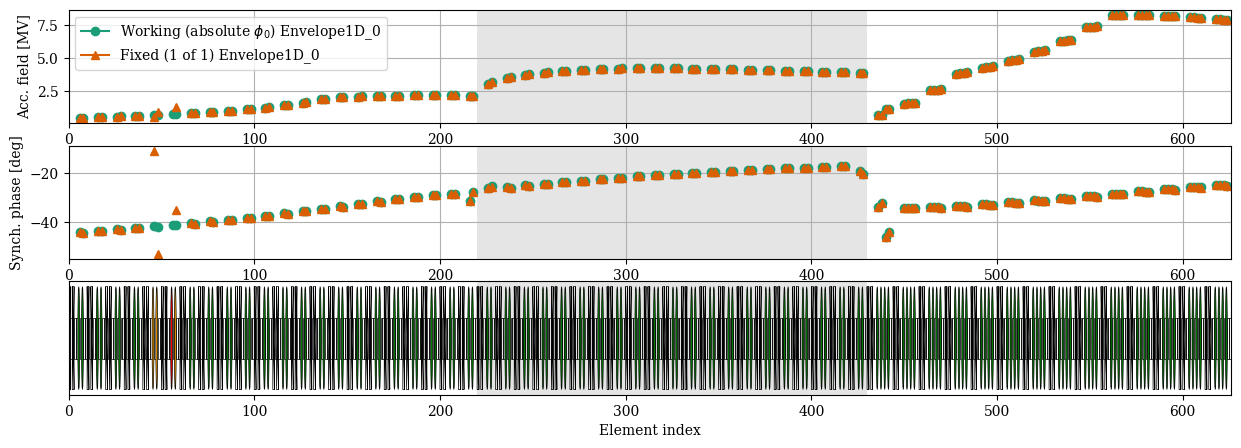

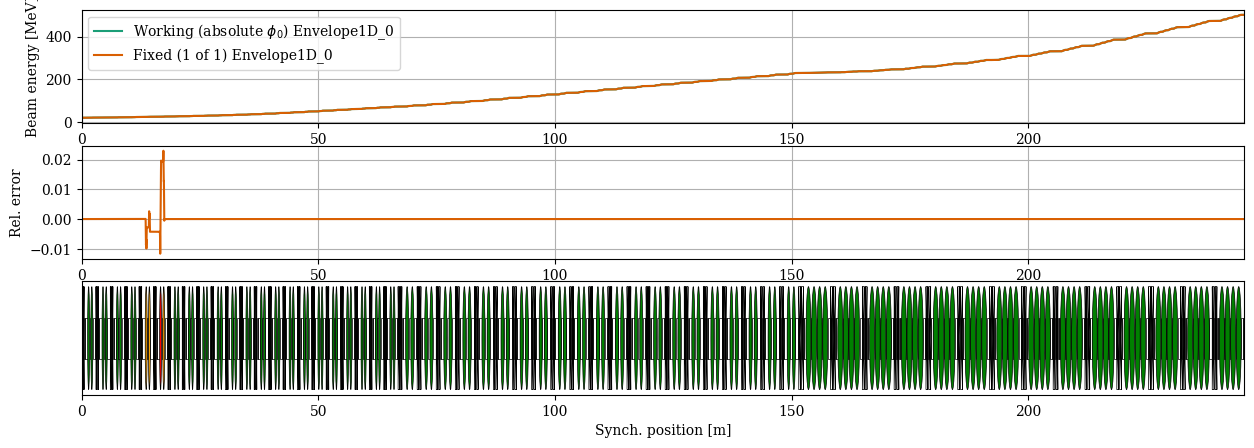

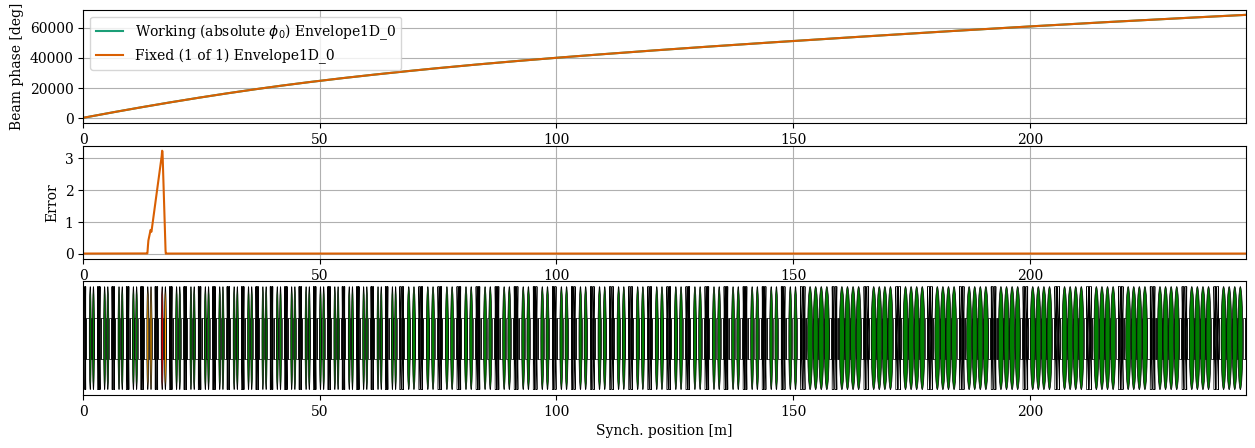

In [14]:
for scenario in fault_scenarios_abs:
    scenario.fix_all()
figs = plot.factory(accelerators_abs, plots_complete, save_fig=False, clean_fig=False)

### Relative phase linac

When downstream cavities are rephased, it is no longer mandatory to retrieve nominal beam phase at the exit of the compensation zone. Here, we try to retrieve the kinetic energy and to minimize the mismatch factor.

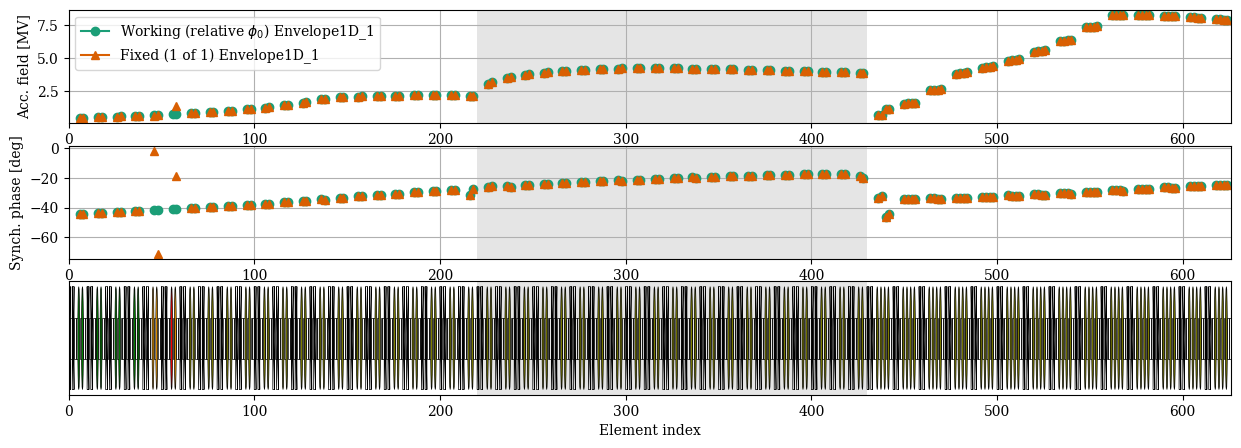

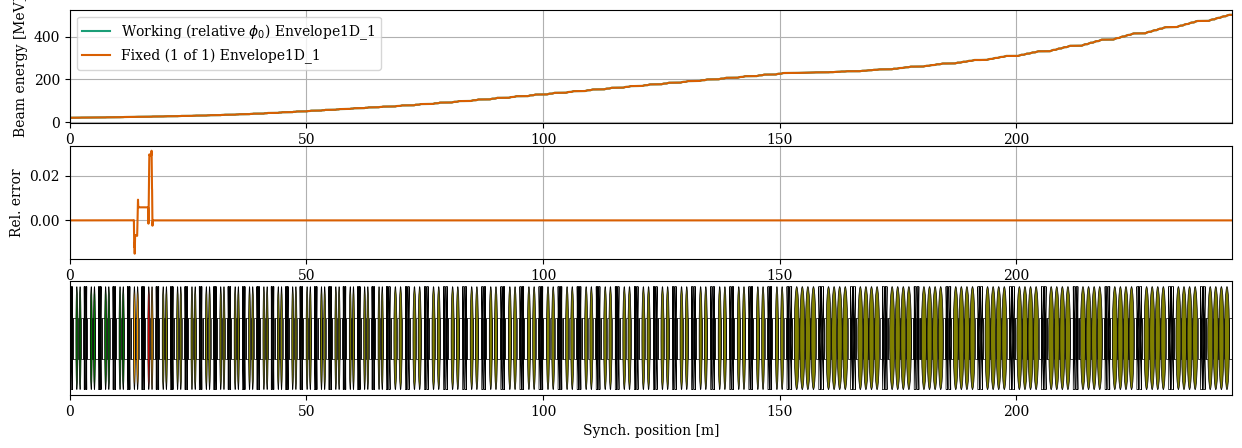

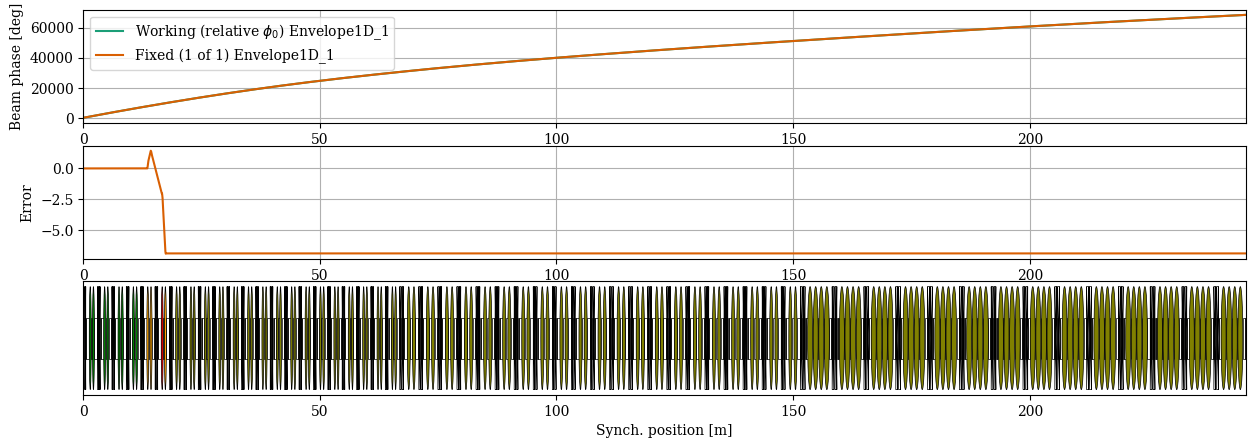

In [15]:
for scenario in fault_scenarios_rel:
    scenario.fix_all()
figs = plot.factory(accelerators_rel, plots_complete, save_fig=False, clean_fig=False)

### Synchronous phase linac

Results will be very similar to the relative phase linac.

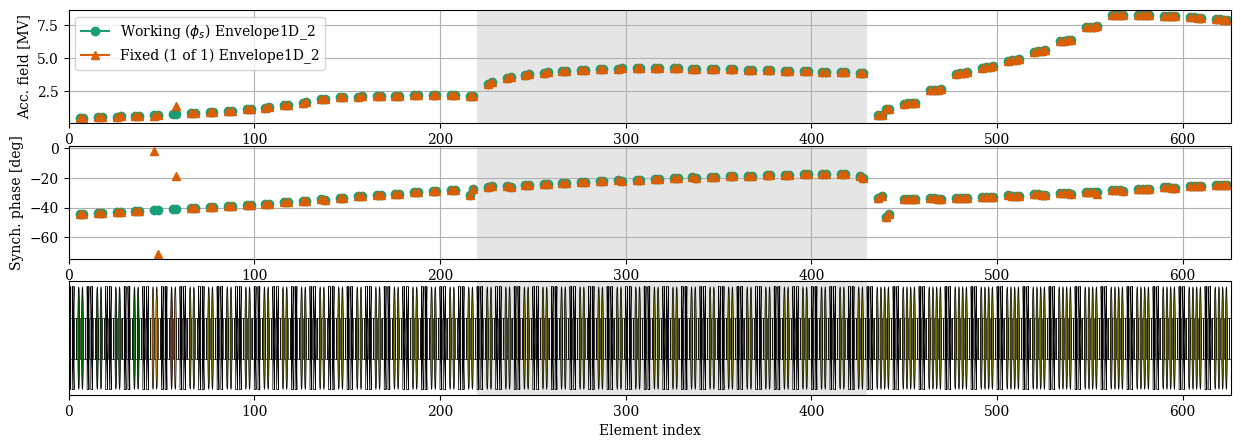

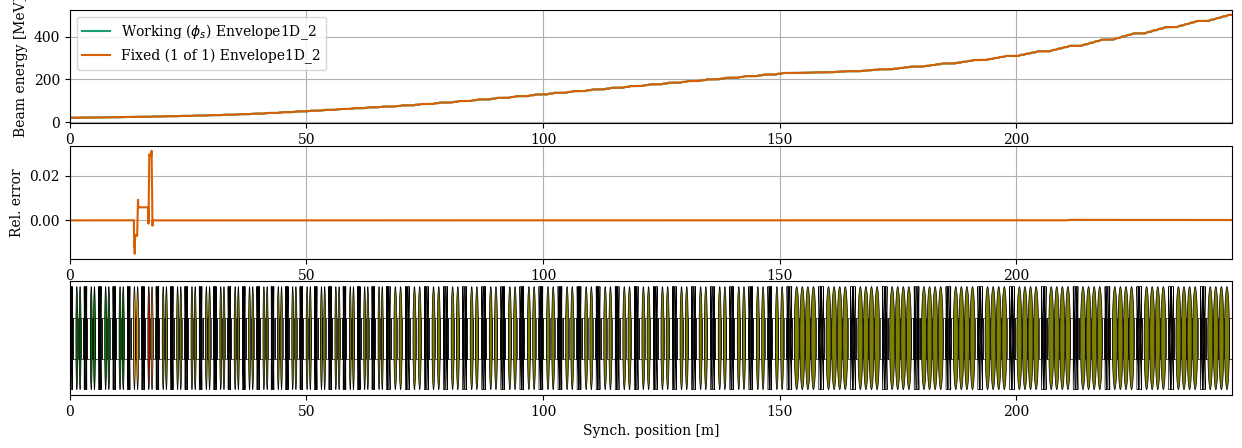

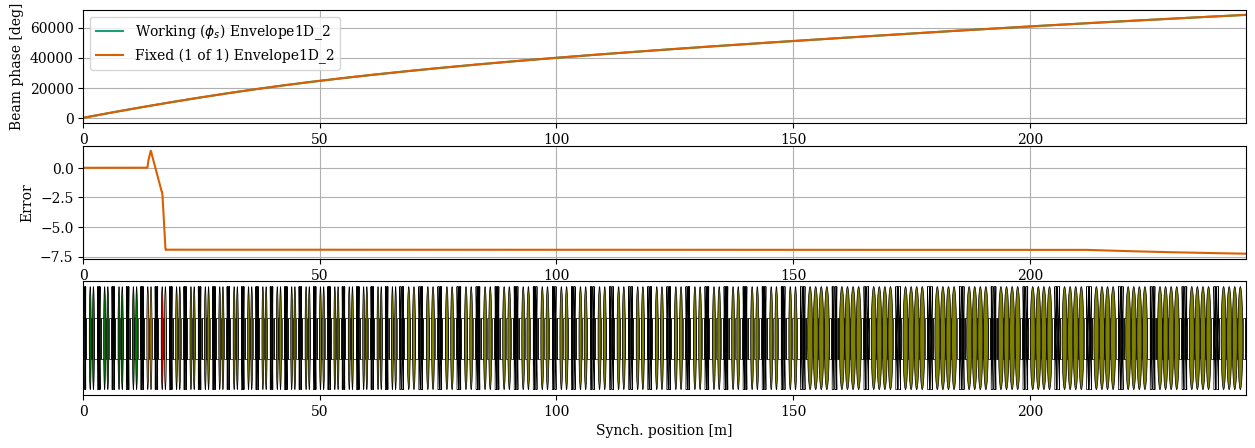

In [16]:
for scenario in fault_scenarios_sync:
    scenario.fix_all()
figs = plot.factory(accelerators_sync, plots_complete, save_fig=False, clean_fig=False)